# An introduction to black-box function approximators

## [Scott Jeen](https://enjeeneer.io/)

### Xchange Seminar, 15th March 2021

**Abstract**

In this talk, I will introduce deterministic and probabilstic black-box function approximators, with applications for timeseries modelling. First, I introduce the multilayer perceptron (neural network) illustrating its ability to model abritrarily complex functions, but highlighting its propensity to overfit the training data. Second, I introduce the Gaussian process (GP), a bayesian, probabilistic approach to function approximation. I visualise how GP's quantify uncertainty, a robust trait in the context of control, but highlight their inability to scale to large datasets. I conclude by applying both techniques to the problem of room temperature prediction. 

## Today's Talk
- My project
- Black-box function approximation
    - **Deterministic approach**: Neural networks and Long-short term memory (LSTMs)
    - **Probabilistic approach**: Gaussian processes (GPs)
- Timeseries applications
- Key takeaways

## My Project

Let's start with this video of one of DeepMind's machine learning agents learning to play the Atari game Breakout [1]. DeepMind feed the agent three pieces of information: 1) The pixel arrangement of the screen, 2) The actions it can take i.e. it can move left or right only, and 3) The score. The task of the agent is to learn to maximise its score by any means necessary. You'll note that, intially, the agent doesn't understand how best to play the game, but after more iterations it begins to get the hang of it. After 600 episodes of play, the agent has worked out the optimal strategy for this game: burrow a channel in either side of the bricks and fire the ball into the space behind the bricks.

## 1. My Project

[![IMAGE ALT TEXT](http://img.youtube.com/vi/TmPfTpjtdgg/0.jpg)](https://www.youtube.com/watch?v=TmPfTpjtdgg "DQN Breakout")

*Video: Deepmind's Deep Q-network solving the Atari game Breakout after 600 episodes of self-play. Paper by [Mnih et. al (2013)](https://arxiv.org/pdf/1312.5602.pdf)*

A couple of years later, DeepMind took things a sterp further to try and conquer the considerably more complex game Go. Now, we're moving from a relatively straight forward state-space to a [state-space with $~10^{170}$ legal positions](https://en.wikipedia.org/wiki/Go_and_mathematics), considerably [more atoms that in the observable universe](https://en.wikipedia.org/wiki/Observable_universe).

DeepMind created a more advanced agent, AlphaGo, and used it to play the world no. 1 Lee Sedol in best of 5 match, [winning 4-1](https://en.wikipedia.org/wiki/AlphaGo_versus_Lee_Sedol). Perhaps the most intersting takeaway from the series was AlphaGo's now infamous move 37 ([see this clip from DeepMind's documentary](https://www.youtube.com/watch?v=HT-UZkiOLv8)). Expert Go players suggest that in the board setup illustrated below, human Go players have long believed that the optimal move is in the margins of the board, but AlphaGo decided to play 5 lines in from the edge; much to the surprise of the audience, and Lee Sedol. This move later proved to be game-winning; AlphaGo had correctly predicted how the board would evolve and that move scuppered its opponent. 

<img class="" src="https://github.com/enjeeneer/talks/blob/main/2021-03-15-UselessGroupXchange/images/move37.png?raw=true" style="width:50%">

<img class="" src="https://github.com/enjeeneer/talks/blob/main/2021-03-15-UselessGroupXchange/images/leesedol.png?raw=true" style="width:50%">

*Figure: **Top:** AlphaGo's infamous Move 37, a counterintuitive move for a human to make with this board set-up, but nonetheless a gaming-winning one. **Bottom:** Lee Sedol, the world no.1 Go player, flumexed by AlphaGo's moves.* 

After a few weeks of training, AlphaGo unearthed knowledge about this game that humans hadn't found after thousands of years of play.

So, why am I telling you all of this? Well, for my PhD project, I think instead of playing Atari games we should play the game of climate change mitigation. Specifically, let's turn the electricity system into a game. The board is the electricity grid, our pieces are energy-intensive devices on the grid, and our goal is to minimise the emissions produced by these devices whilst maintaining a quality of service to society.

<img class="" src="https://github.com/enjeeneer/talks/blob/main/2021-03-15-UselessGroupXchange/images/smartgrid.png?raw=true" style="width:60%">

Of course, this is the grand challenge. In this first instance, my goal is to control a building such that it interacts with the grid most efficiently, and we're doing that in one of Emerson Electric's facilities out in Canada, but more on that later.

### 1.1 Reinforcement Learning
I haven't yet discussed the technique DeepMind used to produce these results; its called [Reinforcement Learning](https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf) [2]. In general, the RL control loop looks something like this:

<img class="" src="https://github.com/enjeeneer/talks/blob/main/2021-03-15-UselessGroupXchange/images/rl_basic.png?raw=true" height='350' width='500'>

*Figure: The RL control loop. Agent's take sequential actions that affect its environment, the environment changes and the agent receives a reward for their action. Adapted from [Episode 1 of David Silver's RL Youtube series](https://www.youtube.com/watch?v=2pWv7GOvuf0&t=1757s)*

The brain here represents the agent, the globe represents its environment. The agent can take actions in the environment, after which the environment feeds it some reward and tells it what the new state is. The agent's goal is maximise its cumulative reward, i.e. find the set of actions given states that win the game or meet its control objective.

More formally, the RL control loop looks something like this:

<img class="" src="https://github.com/enjeeneer/talks/blob/main/2021-03-15-UselessGroupXchange/images/rl_formal.png?raw=true">

*Figure: The formalised RL control loop.* 

Where the agent observes the state $s$ through some sensor that is often noisy, it feeds the state into its control policy which selects an action $a$ given $s$, sending the agent through a transition represented by $P$ to new state $s'$. This transition, often called the system dynamics, can be modelled as a black box function. I'm going to spend the rest of this walkthrough discussing how the ways in which you can approximate a function using black methods, when we should do so, and the limitations of doing so.

## 2. Black-box Function Approximation

### 2.1 Two approaches to modelling

Generally when we model a function using a black-box approximator, we can select (informally) from two sets of models, these are:

- **Deterministic models:** Do not contain elements of randomness; everytime the model is run with the same intial conditions it produces identical results.
- **Probabilistic models:** Include elements of randomness; trails with identical initial conditions will produce different results.

As you can imagine, these are philosophically contradictory ways of thinking about modelling. The first assumes that there is a definite underlying function to be modelled, and with enough data we will be able to obtain it with sufficient accuracy. The second, assumes the world is random, we will never find the *true* underlying function because every function is subject to irreducible randomness or uncertainty in the world (cf. [aleatoric uncertainty](https://en.wikipedia.org/wiki/Uncertainty_quantification)). The two eminent modelling techniques in these camps are Neural Networks (deterministic) and Gaussian Processes (probabilistic). I'll run through an example explaining the differences between the two.

### 2.2 Determinstic models


Firstly, we need some data. Let's imagine we've collected 5 samples from the world that were produced by a function we'd like to infer. For simplicity, we'll assume this model is one-dimensional with inputs $x_i$ and outputs $y_i$ creating a dataset of input-output pairs $\mathrm{D} = \{x_i,y_i\}_i^N$ where we assume the relationship between the variables is $y_i = f(x_i)$. Our goal is to infer the function $f(\cdot)$ from $\mathrm{D}$:

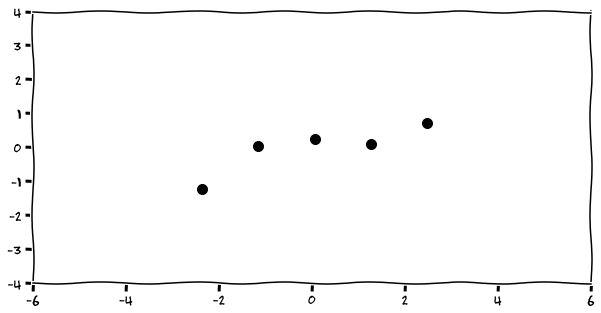

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import os

path = os.getcwd()

# generate data
np.random.seed(12)
N = 5
x_true = np.linspace(-6,6,100)
y_true = np.sin(2*np.pi/x_true) + x_true*0.1 + np.random.randn(x_true.shape[0])
y_true = np.reshape(y_true,(-1,1))

# get samples
samples = np.linspace(30,70,5).astype(int)
x = x_true[samples].reshape(-1,1)
y = y_true[samples].reshape(-1,1)

# plot the data
with plt.xkcd():
    fig = plt.figure(figsize=(10,5))
    plt.scatter(x, y, 100, 'k', 'o', zorder=100)
    plt.xlim([-6,6])
    plt.ylim([-4,4])
    plt.savefig(path+'/images/1_data.png', dpi=300)
    plt.show()

<img class="" src="images/1_data.png">

In the first instance, let's think about modelling this data deterministically. We might think that there is a linear relationship in the underlying data, so we model it as a straight line and manipulate the parameters of our straight line until the error between our line and the data in minimised. Our linear model takes the form:

$$
f(x) = {\color{red}{w_0}} + {\color{blue}{w_1} x}
$$

In [15]:
from ipywidgets import interact
import ipywidgets as widgets

def y_linear_plot(w1, w0):
    
    y_lin = w1*x_true+w0
    y_err = w1*x+w0
    
    with plt.xkcd():
        fig = plt.figure(figsize=(10,5))
        plt.xlim([-6,6])
        plt.ylim([-4,4])
        plt.scatter(x, y, 100, 'k', 'o', zorder=100)
        plt.plot(x_true, y_lin)
        plt.vlines(x=x, ymin=y_err, ymax=y, colors='green', ls=':', lw=2)
        plt.savefig(path+'/images/2_data.png', dpi=300)
        plt.show()

interact(y_linear_plot, w1=widgets.FloatSlider(value=0.75, min=-5, max=5, step=0.25),
                    w0=widgets.FloatSlider(value=-.25, min=-5, max=5, step=0.25))


interactive(children=(FloatSlider(value=0.75, description='w1', max=5.0, min=-5.0, step=0.25), FloatSlider(val…

<function __main__.y_linear_plot(w1, w0)>

We can set the parameters of our linear model such that the error is pretty small, but we also are know that the underlying function is unlikely to be a truly linear. Instead, we could improve on this by assuming our basis function is no longer linear, but rather polynomial, taking the form:

$$
f(x) = {\color{red}{w_0}} + {\color{blue}{w_1}} x + {\color{green}{w_2}} x^2 + {\color{orange}{w_3}} x^3
$$

In [16]:
def y_poly_plot(w0, w1, w2, w3):
    
    y_poly = w0 + w1*x_true + w2*(x_true**2) + w3*(x_true**3)
    y_polyerr = w0 + w1*x + w2*(x**2) + w3*(x**3)
    
    with plt.xkcd():
        fig = plt.figure(figsize=(10,5))
        plt.xlim([-6,6])
        plt.ylim([-4,4])
        plt.scatter(x, y, 100, 'k', 'o', zorder=100)
        plt.plot(x_true, y_poly)
        plt.vlines(x=x, ymin=y_polyerr, ymax=y, colors='green', ls=':', lw=2)
        plt.savefig(path+'/images/3_data.png', dpi=300)
        plt.show()

interact(y_poly_plot,
             w0=widgets.FloatSlider(value=-1, min=-7, max=7, step=0.5),
             w1=widgets.FloatSlider(value=-.5, min=-7, max=7, step=0.5),
             w2=widgets.FloatSlider(value=1.5, min=-7, max=7, step=0.5),
             w3=widgets.FloatSlider(value=1, min=-7, max=7, step=0.5),
        )

interactive(children=(FloatSlider(value=-1.0, description='w0', max=7.0, min=-7.0, step=0.5), FloatSlider(valu…

<function __main__.y_poly_plot(w0, w1, w2, w3)>

With enough time, we could probably find a set of parameters for our polynomial that approximate that dataset pretty closely.

Neural networks take this approach to the extreme. We've looked at two basis functions so far, the linear model and the polynomial, for efficient computation neural networks tend to use the Rectified Linear Unit (ReLU) basis function, although they are usually called the *activation function* for reasons that will become clear shortly. 

ReLUs take the following form:

$$
f(x) = \max (0 ,  {\color{blue}{w_1}} x + {\color{red}{w_0}})
$$

and look like a ramp function when plotted.

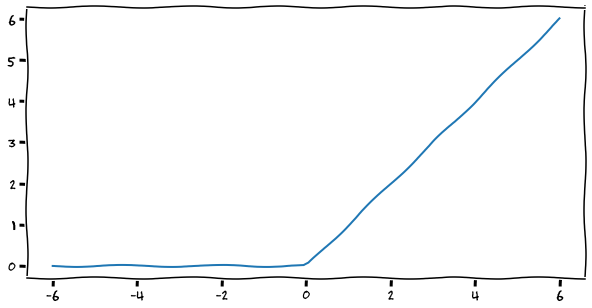

In [17]:
def relu(w0_max, w1_max):
    return np.maximum(0, w1_max*x_true + w0_max)

relu0= relu(0,1)

with plt.xkcd():
    fig = plt.figure(figsize=(10,5))
    plt.plot(x_true, relu0)
    plt.savefig(path+'/images/4_data.png', dpi=300)
    plt.show()

They are named activation functions because they *activate* the output for a certain input. Neural networks are a linear combination of these activation functions, the output of which can, surprisingly model *any* continuous function (cf. [the universal function approximator theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem#:~:text=In%20the%20mathematical%20theory%20of,given%20function%20space%20of%20interest.&text=Most%20universal%20approximation%20theorems%20can%20be%20parsed%20into%20two%20classes.)). Inspired by [this great blog post](https://towardsdatascience.com/can-neural-networks-really-learn-any-function-65e106617fc6) from Brendan Fortuner, I tried to model our dataset using four ReLUs:

/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


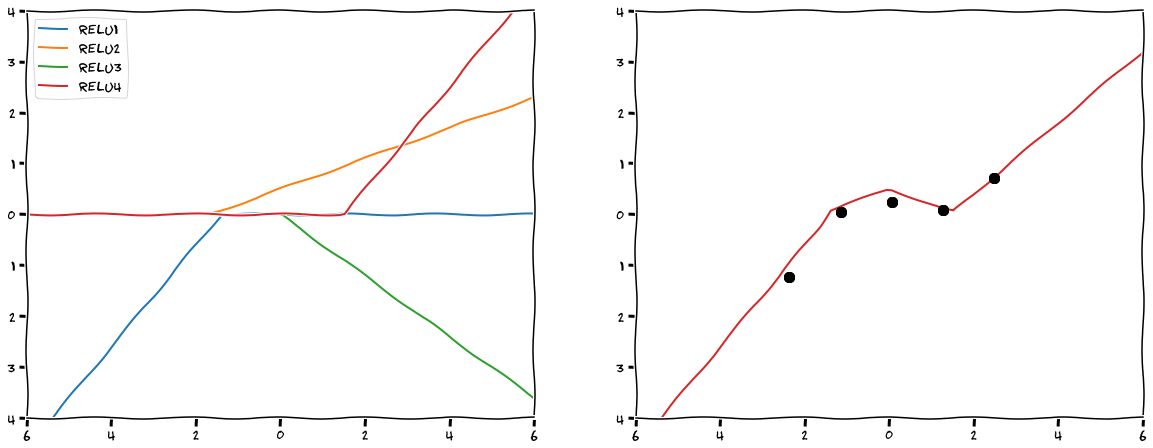

In [18]:
def relu(w0_max, w1_max):
    return np.maximum(0, w1_max*x_true + w0_max)
    
relu1 = relu(-1.4,-1)
relu2 = relu(0.5,0.3)
relu3 = relu(0,0.6)
relu4 = relu(-1.5,1)

zipped_relus = [-relu1,relu2,-relu3,relu4]
activations = -relu1+relu2-relu3+relu4

with plt.xkcd():
    fig = plt.figure(figsize=(20,7.5))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    ax1.set_xlim([-6,6])
    ax1.set_ylim([-4,4])
    ax2.set_xlim([-6,6])
    ax2.set_ylim([-4,4])
    
    for i, z in enumerate(zipped_relus):
        ax1.plot(x_true, z, label='relu{}'.format(i+1))
        ax1.legend(loc='upper left')
        ax2.scatter(x, y, 100, 'k', 'o', zorder=100)
        plt.savefig(path+'/images/5_data.png', dpi=300)
        ax2.plot(x_true, activations)


Not a bad estimation! On the left you can see when each of the four ReLUs activate, and how they affect the function once activated. On the right, you can see the sum of those four activations.

In effect, we have created a neural network with four nodes by hand. You can imagine that with more ReLUs we could produce a smoother fit to the data, 2 sets of 10 ReLUs would look something like this:

<img class="" src="images/mlp.png" style="width:60%">

We'll pass our dataset through a neural network of 14 nodes, optimise and make predictions of the output. Here's what we get:

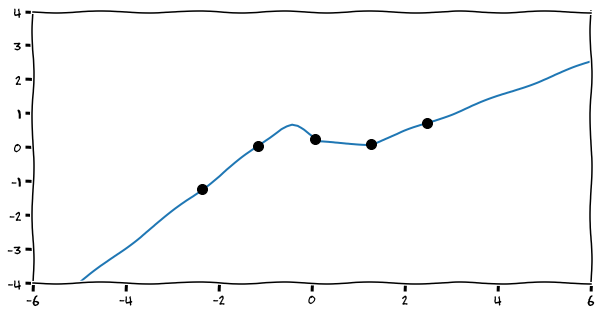

In [20]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Sequential

# build the model
model = Sequential([
Dense(14, activation='relu', kernel_initializer='he_normal', input_shape=(1,)),
Dense(1)
])

optimizer = tf.optimizers.Adam()
model.compile(optimizer=optimizer, loss='mse')

model.fit(x,y, epochs=5000, verbose=0)

# make predictions
y_hat = model.predict(x_true)

# plot
with plt.xkcd():
    fig = plt.figure(figsize=(10,5))
    plt.xlim([-6,6])
    plt.ylim([-4,4])
    plt.scatter(x, y, 100, 'k', 'o', zorder=100)
    plt.plot(x_true, y_hat)
    plt.savefig(path+'/images/6_data.png', dpi=300)
    plt.show()


That looks even better! The function smoothly fits the data in a way that looks quite probable. Let's see how our model compares to the true function:

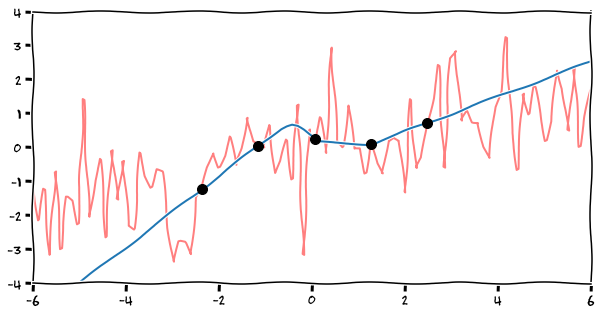

In [21]:
# plot true function
with plt.xkcd():
    fig = plt.figure(figsize=(10,5))
    plt.xlim([-6,6])
    plt.ylim([-4,4])
    plt.scatter(x, y, 100, 'k', 'o', zorder=100)
    plt.plot(x_true, y_hat)
    plt.plot(x_true, y_true, color='red', alpha=0.5, zorder=1)
    plt.savefig(path+'/images/7_data.png', dpi=300)
    plt.show()

Ah. Things have gone awry. The neural network has completely mischaracterised the underlying function. We can forgive the neural network for getting it so wrong, but it would have been great if it had told us it wasn't sure! The neural network is arrogant, it thinks there is only one function that could have produced the data and that it's nailed it after seeing five datapoints. It cannot possibly know how the function behaves when $x < -4$ or when $x > 4$ yet it still makes confident assertions about $y$ there. Ideally, we'd like an approach that tells us when it is confident in its predictions and when it is less confident. To do so, we'll now turn to the probabilistic approach.

## Probabilistic models: Gaussian Processes

We know that there are an infinite number of functions that could have produced the data we observe, and that we'll never be able to say for certain which one of these infinite functions is *correct*, but we'd like to know which subset of these functions is most probable. The question becomes: how can we narrow our solution space from *every* possible function to a subset that could have feasibly produced the data we observe. 

We use [Bayes' rule](https://en.wikipedia.org/wiki/Bayes%27_theorem) to narrow the solution space, which tells us how to update our beliefs about the world badsed on the evidence we've seen:  

$$
P (A | B) = \frac{P(B | A) P(A)}{P(B)}
$$

and in the setting of functions and data it looks like:

$$
P (\textbf{f} | \textbf{D}) = \frac{P(\textbf{D} | \textbf{f}) P(\textbf{f})}{P(\textbf{D})}
$$

The latter provides a *predictive posterior distribution* over the function space given the data we have observed i.e. of the infinite set of functions available to us, which are the most likely given the data. I'm going to focus first on the *prior* $P(\textbf{f}), which is where we as modellers can input our beliefs about the world *prior* to seeing any data. Let's return to our original dataset and think about our prior beliefs:

<img class="" src="images/1_data.png">

In [23]:
from scipy.spatial.distance import cdist

# reshape x
x_true = x_true.reshape(-1,1)

# radial basis function kernel
def rbf_kernel(x1, x2, var, lscale):
    if x2 is None:
        d = cdist(x1, x1)
    else:
        d = cdist(x1, x2)
    K = var*np.exp(-np.power(d,2)/(lscale**2))
    return K

# periodic kernel
def periodic_kernel(x1, x2, var, period, lscale):
    if x2 is None:
        d = cdist(x1,x1)
    else:
        d = cdist(x1,x2)
    return var*np.exp(-(2*np.sin((np.pi/period)*np.sqrt(d))**2)/lscale**2)

# noise kernel
def white_kernel(x1, x2, var):
    if x2 is None:
        return var*np.eye(x1.shape[0])
    else:
        return np.zeros(x1.shape[0], x2.shape[0])
    
# our prediction function
def gp_prediction(x, y, x_true, lscale, var, period=None, rbf=True):
    
    if rbf:
        k_starX = rbf_kernel(x_true, x, var, lscale)
        k_xx = rbf_kernel(x, None, var, lscale)
        k_starstar = rbf_kernel(x_true, None, var, lscale)
    
        mu = k_starX.dot(np.linalg.inv(k_xx)).dot(y).flatten()
        var = k_starstar - k_starX.dot(np.linalg.inv(k_xx)).dot(k_starX.T)
        return mu, var
    
    else:
        k_starX = periodic_kernel(x_true, x, var, period, lscale)
        k_xx = periodic_kernel(x, None, var, period, lscale)
        k_starstar = periodic_kernel(x_true, None, var, period, lscale)
    
        mu = k_starX.dot(np.linalg.inv(k_xx)).dot(y).flatten()
        var = k_starstar - k_starX.dot(np.linalg.inv(k_xx)).dot(k_starX.T)
        return mu, var
    
# build the kernels
K_rbf = rbf_kernel(x_true, None, 1.0, 2.0)
K_per = periodic_kernel(x_true, None, 1, 4, 2)
K_white = white_kernel(x_true, None, 0.001)

# build mean vector
mu = np.zeros(x_true.shape[0])

# generate samples from gaussian distribution
f_rbf = np.random.multivariate_normal(mu, K_rbf, 20)
f_per = np.random.multivariate_normal(mu, K_per, 20)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: covariance is not positive-semidefinite.


We may think that the functions are likely to be quite smooth. Perhaps we know that the data has been sampled from a process that changes state slowly and smoothly e.g. the tide height in a harbour throughout a day. Here are 20 functions sampled from the infinite set of *smooth* functions produced by the [Radial Basis Function](https://en.wikipedia.org/wiki/Radial_basis_function).

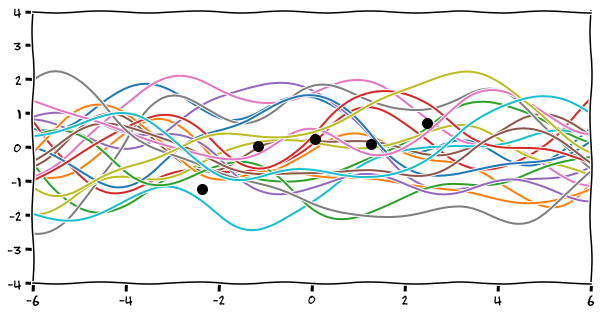

In [24]:
# plot rbf kernel
with plt.xkcd():
    fig = plt.figure(figsize=(10,5))
    plt.scatter(x, y, 100, 'k', 'o', zorder=100)
    plt.plot(x_true, f_rbf.T)
    plt.xlim([-6,6])
    plt.ylim([-4,4])
    plt.savefig(path+'/images/8_data.png', dpi=300)
    plt.show()

Our we might think the process isn't quite so smooth and perhaps varies more stochastically. Here are 20 functions sampled using a periodic basis function:

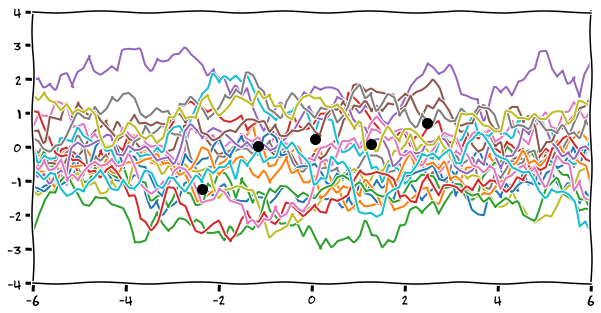

In [25]:
# plot periodic kernel
with plt.xkcd():
    fig = plt.figure(figsize=(10,5))
    plt.scatter(x, y, 100, 'k', 'o', zorder=100)
    plt.plot(x_true, f_per.T)
    plt.xlim([-6,6])
    plt.ylim([-4,4])
    plt.savefig(path+'/images/9_data.png', dpi=300)
    plt.show()

From this prior, we can reject each function from the infinite set that does not pass through our datapoints by optimising the log marginal likelihood of the functions (a description of which is outside the scope of this talk).

If we return to our Radial Basis Function kernel, reject all the functions that don't pass through our datapoints, plot 1000 of the remaining functions we get something that looks like this:

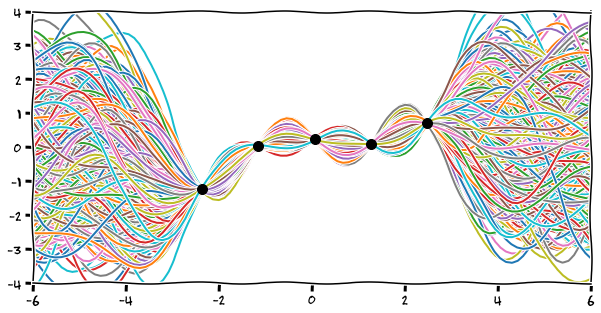

In [26]:
# make predictions
mu_star, var_star = gp_prediction(x, y, x_true, lscale=1.5, var=1.5, period=None, rbf=True)
f_star = np.random.multivariate_normal(mu_star, var_star, 1000)
f_star_mean = f_star.mean(axis=0)
f_star_std = f_star.std(axis=0)

# plot predictions
with plt.xkcd():
    fig = plt.figure(figsize=(10,5))
    plt.scatter(x, y, 100, 'k', 'o', zorder=100)
    plt.plot(x_true, f_star.T)
    plt.xlim([-6,6])
    plt.ylim([-4,4])
    plt.savefig(path+'/images/10_data.png', dpi=300)
    plt.show()

Now we have a plot that accepts there are many reasonable explanations for the data we observe. We can then take the mean and standard deviation of the distribution of these function and create a plot with confidence intervals:

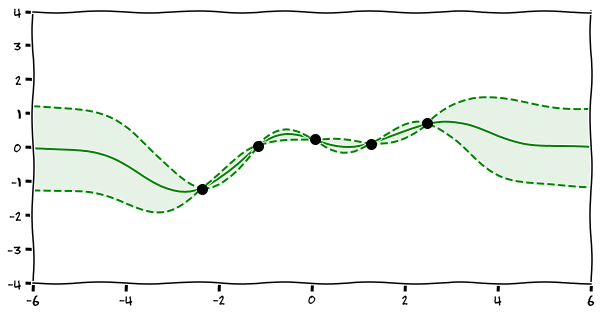

In [27]:
# plot predictions
with plt.xkcd():
    fig = plt.figure(figsize=(10,5))
    plt.scatter(x, y, 100, 'k', 'o', zorder=100)
    plt.plot(x_true, f_star_mean, color='g')
    plt.plot(x_true, f_star_mean+f_star_std, color='g', linestyle='--')
    plt.plot(x_true, f_star_mean-f_star_std, color='g',  linestyle='--')
    plt.fill_between(x_true.flatten(), f_star_mean+f_star_std, f_star_mean-f_star_std, alpha=0.1, color='g')
    plt.xlim([-6,6])
    plt.ylim([-4,4])
    plt.savefig(path+'/images/11_data.png', dpi=300)
    plt.show()

Now the black box is telling where it is more and less confident. In the context of control, or reinforcement learning, this is much more robust as the agent to be wary when there is uncertainty in the state of the system. This modelling technique is called a [Gaussian Process](http://www.gaussianprocess.org/gpml/chapters/RW.pdf) [3].

## Drawbacks
- Expensive to compute; N > ~50,000 prohibitively large
- Prior knowledge remains crucial

# Timeseries applications

Many of the problems we tackle in our group can be described as [timeseries](https://en.wikipedia.org/wiki/Time_series), that is, the inputs and outputs of the system are indexed by time. Examples include: the flow of material through a maufacturing plant, CO2 air concentration, or daily energy generation from a solar panel. In such scenarios, we can take advantage of the sequential nature of the output to inform our model. 

By way of example, I'm going to use the two techniques discussed thus far to predict the time-varying temperature in a coldstorage facility. Let's have a look at the data first:

<img class="" src="images/temp_true.png" width='2000' height='1000'>



Plotted in blue is the temperature of the coldstore in degrees centrigrade sampled at 3 minute intervals. The washed out lines represent features of the system I believe affects the temperature of the cold store, there are 40 in total. These include but are not limited to:
- Outside weather
- Power usage in the chillers
- Wall/floor temperature
- etc.

I model the temperature as a function of these inputs at some number of timesteps prior to the timestep of interest for both a neural network (specifically an LSTM, [see this excellent blog post for more info](https://distill.pub/2019/memorization-in-rnns/)) and a GP. The output of the LSTM is a function of the 10 previous timesteps and the GP is a function of only the previous timestep. Here are the results, firstly the LSTM:


<img class="" src="images/lstm.png" width='2000' height='1000'>

<img class="" src="images/gp.png" width='2000' height='1000'>

<img class="" src="images/gp_test.png" width='2000' height='1000'>

I have 9 months of data at the coldstorage facility (N ~ 400,000). The advantage of the LSTM is that it can use all of this data, meaning it can explore more of the state space, and make better predictions in those out-of-didtribtion times. The GP can only use ~10% of the dataset for training meaning it cannot explore the state space in the same way the neural network can, but it can limit the damage by quanitifying its uncertainty.

## Key Takeaways
- Black box function approximators can model *any* continuous function in theory 
- Deterministic techniques effective with large (N > $10^5$) datasets 
- Probabilistic techniques more robust in low data regimes thanks to uncertainty quantification
- GPs are limited by their expensive computations (N must be < $10^5$) 
- Both approaches can be used to model complex timeseries datasets

# Thanks!
- Notes: https://enjeeneer.io/cv/cv.pft
- Thanks to [Carl Henrik Ek](http://carlhenrik.com/), Dept. of Computer Science for inspiring these slides
- Questions?

# Further Reading
**Further explanations on why these techniques wor:k**
- [Can neural networks solve any problem?](https://towardsdatascience.com/can-neural-networks-really-learn-any-function-65e106617fc6)
- [Visualising how LSTMs make predictions](https://distill.pub/2019/memorization-in-rnns/)

**How can you build these in practice?**
- Neural nets: [Introduction to deep learning with tensorflow](https://machinelearningmastery.com/tensorflow-tutorial-deep-learning-with-tf-keras/)
- GPs: [GP regression on molecules](https://towardsdatascience.com/gaussian-process-regression-on-molecules-in-gpflow-ee6fedab2130)
- LSTMs: [LSTMs for timeseries prediction](https://towardsdatascience.com/lstm-for-time-series-prediction-de8aeb26f2ca)

# References

[1] Mnih, Volodymyr, et al. "Playing atari with deep reinforcement learning." arXiv preprint arXiv:1312.5602 (2013).

[2] Sutton, Richard S., and Andrew G. Barto. Reinforcement learning: An introduction. MIT press, 2018.

[3] Rasmussen, Carl Edward. "Gaussian processes in machine learning." Summer school on machine learning. Springer, Berlin, Heidelberg, 2003.